# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [358]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold

from tqdm.auto import tqdm

In [359]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [360]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [361]:
#df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [362]:
df_reviews = pd.read_csv(r'C:\Users\vlady\Downloads\imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [363]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


## EDA

Let's check the number of movies and reviews over years.

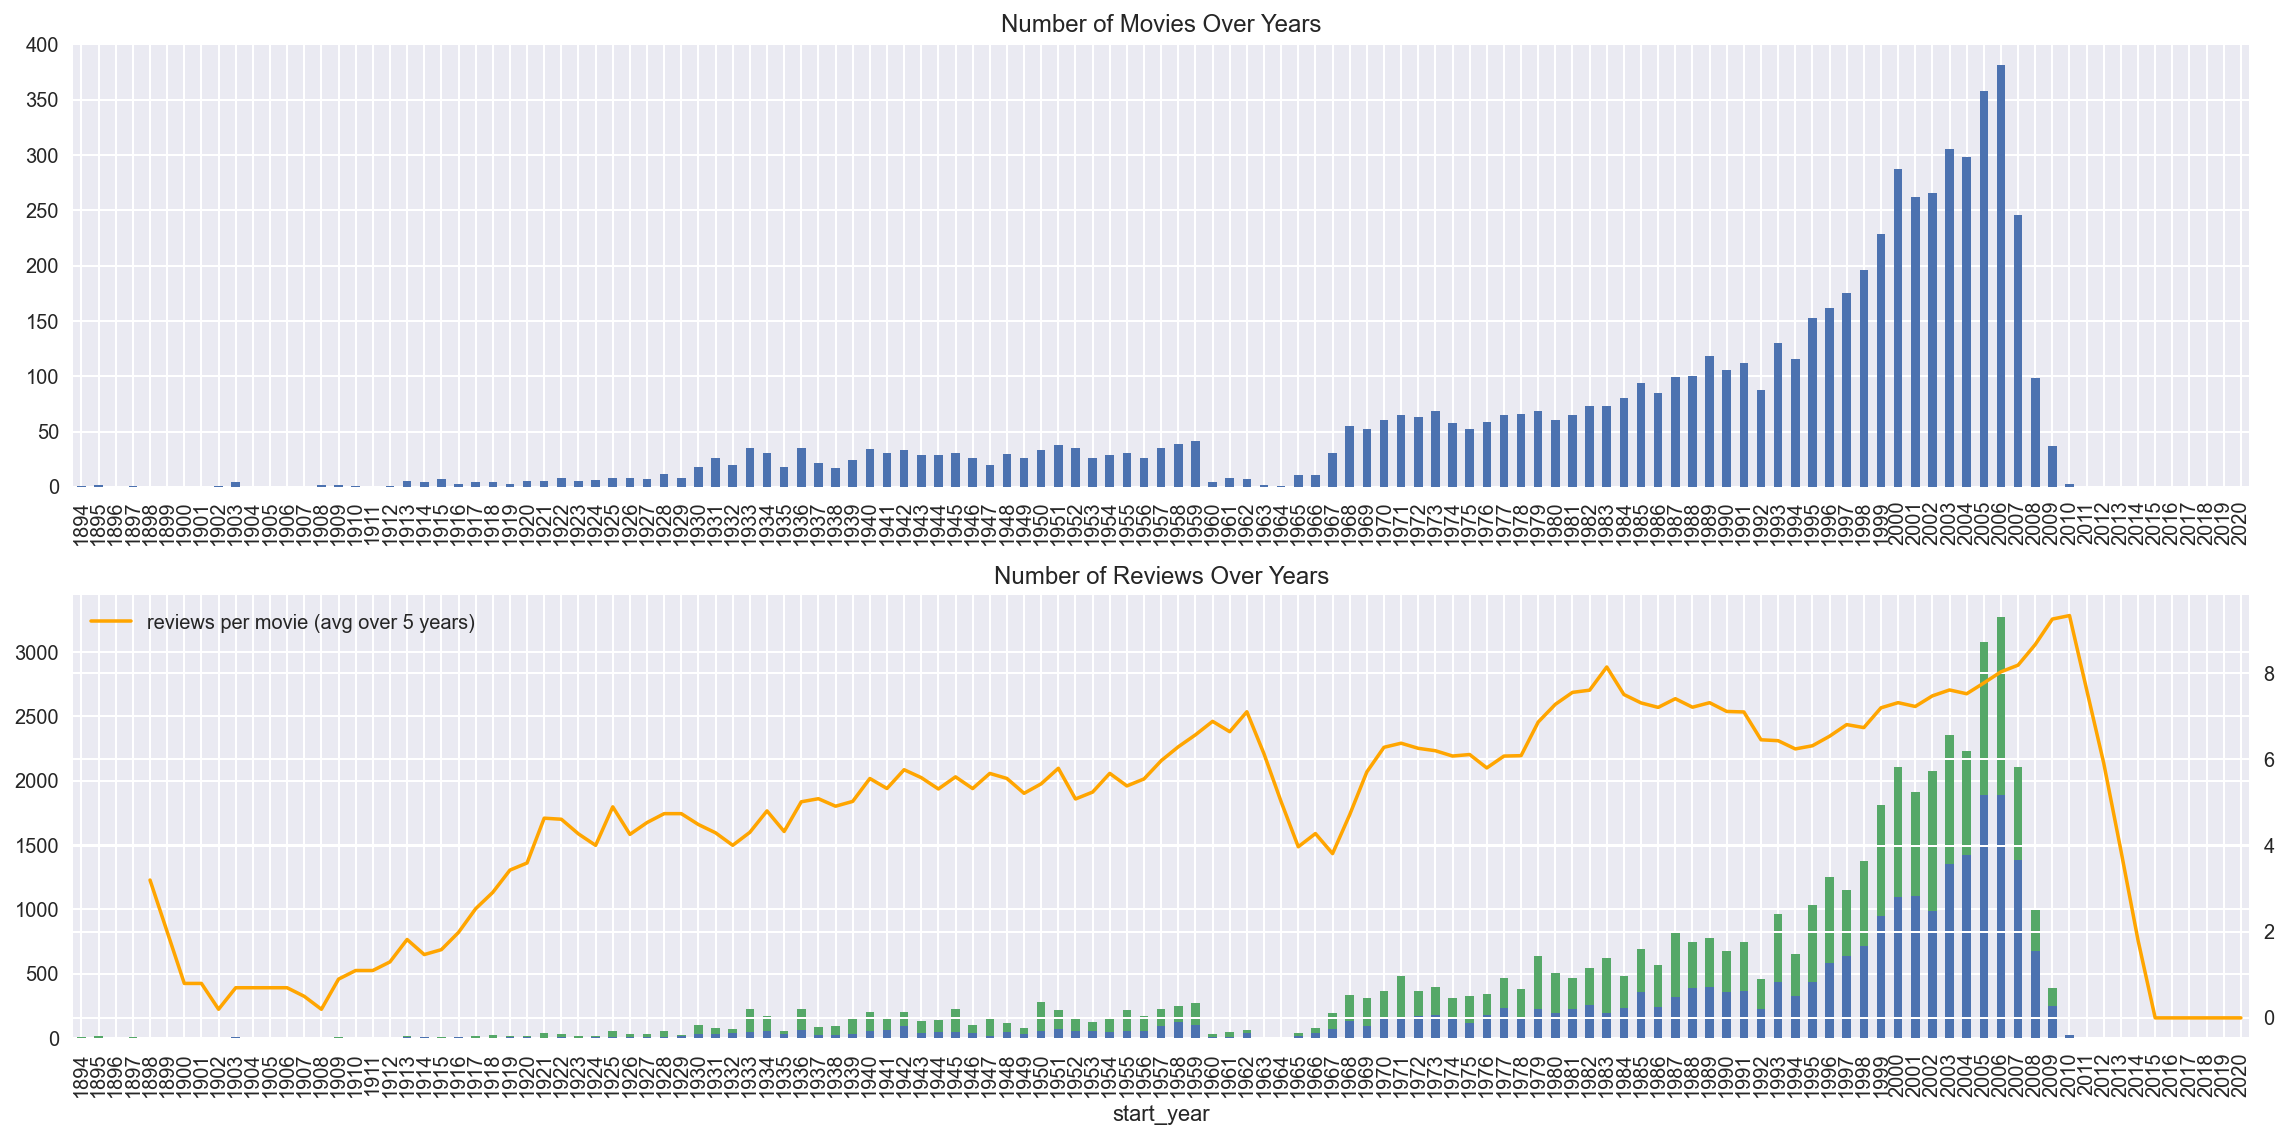

In [364]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()


dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)


dft1.plot(kind='bar', ax=ax);
ax.set_title('Number of Movies Over Years');

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
#dft2
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

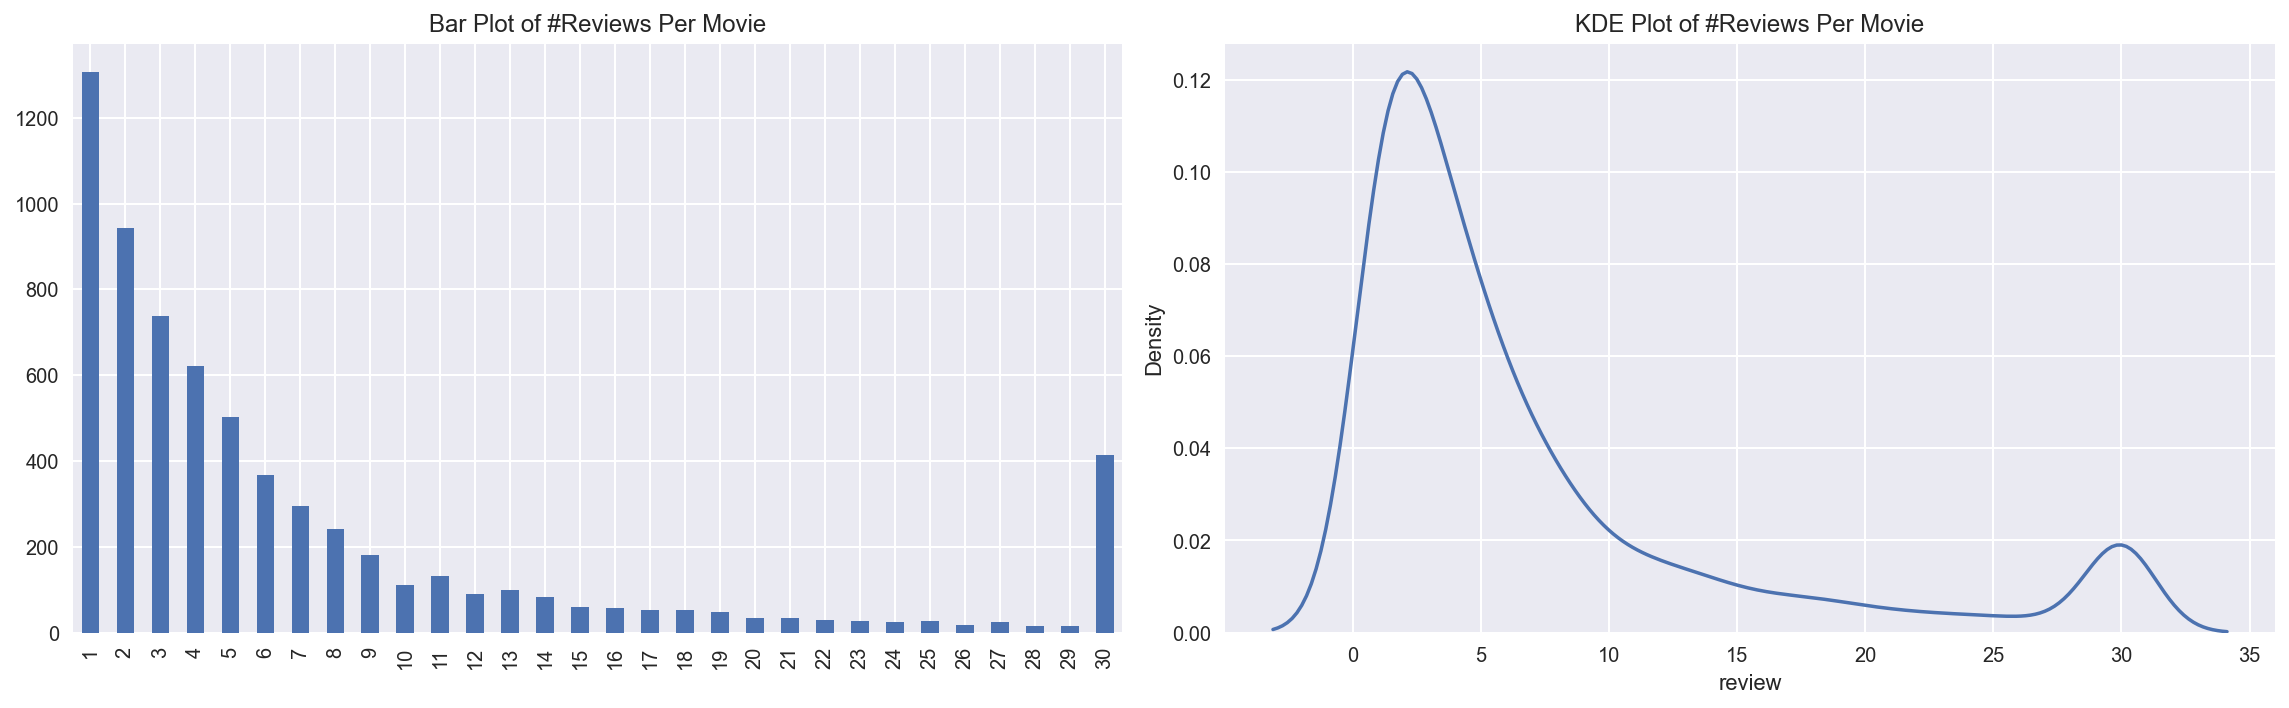

In [365]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [366]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

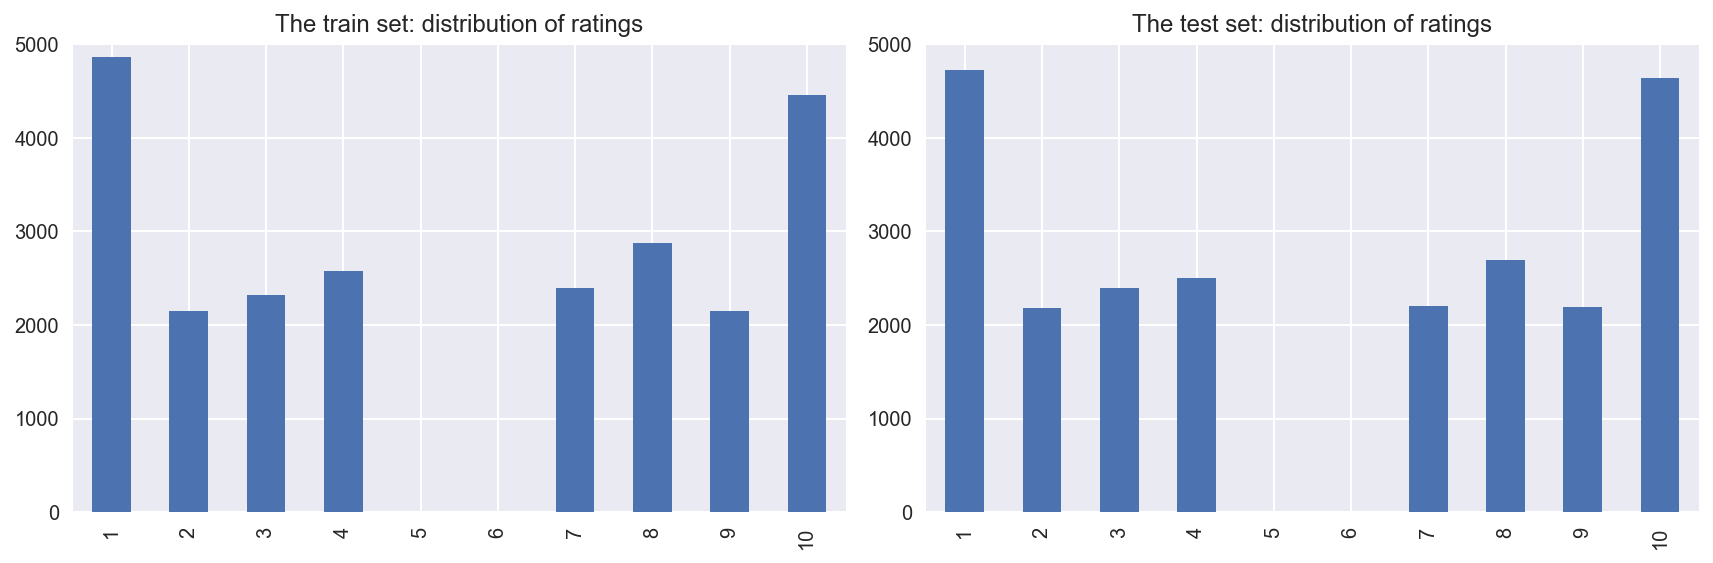

In [367]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

C:\Users\vlady\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\vlady\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\vlady\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\vlady\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


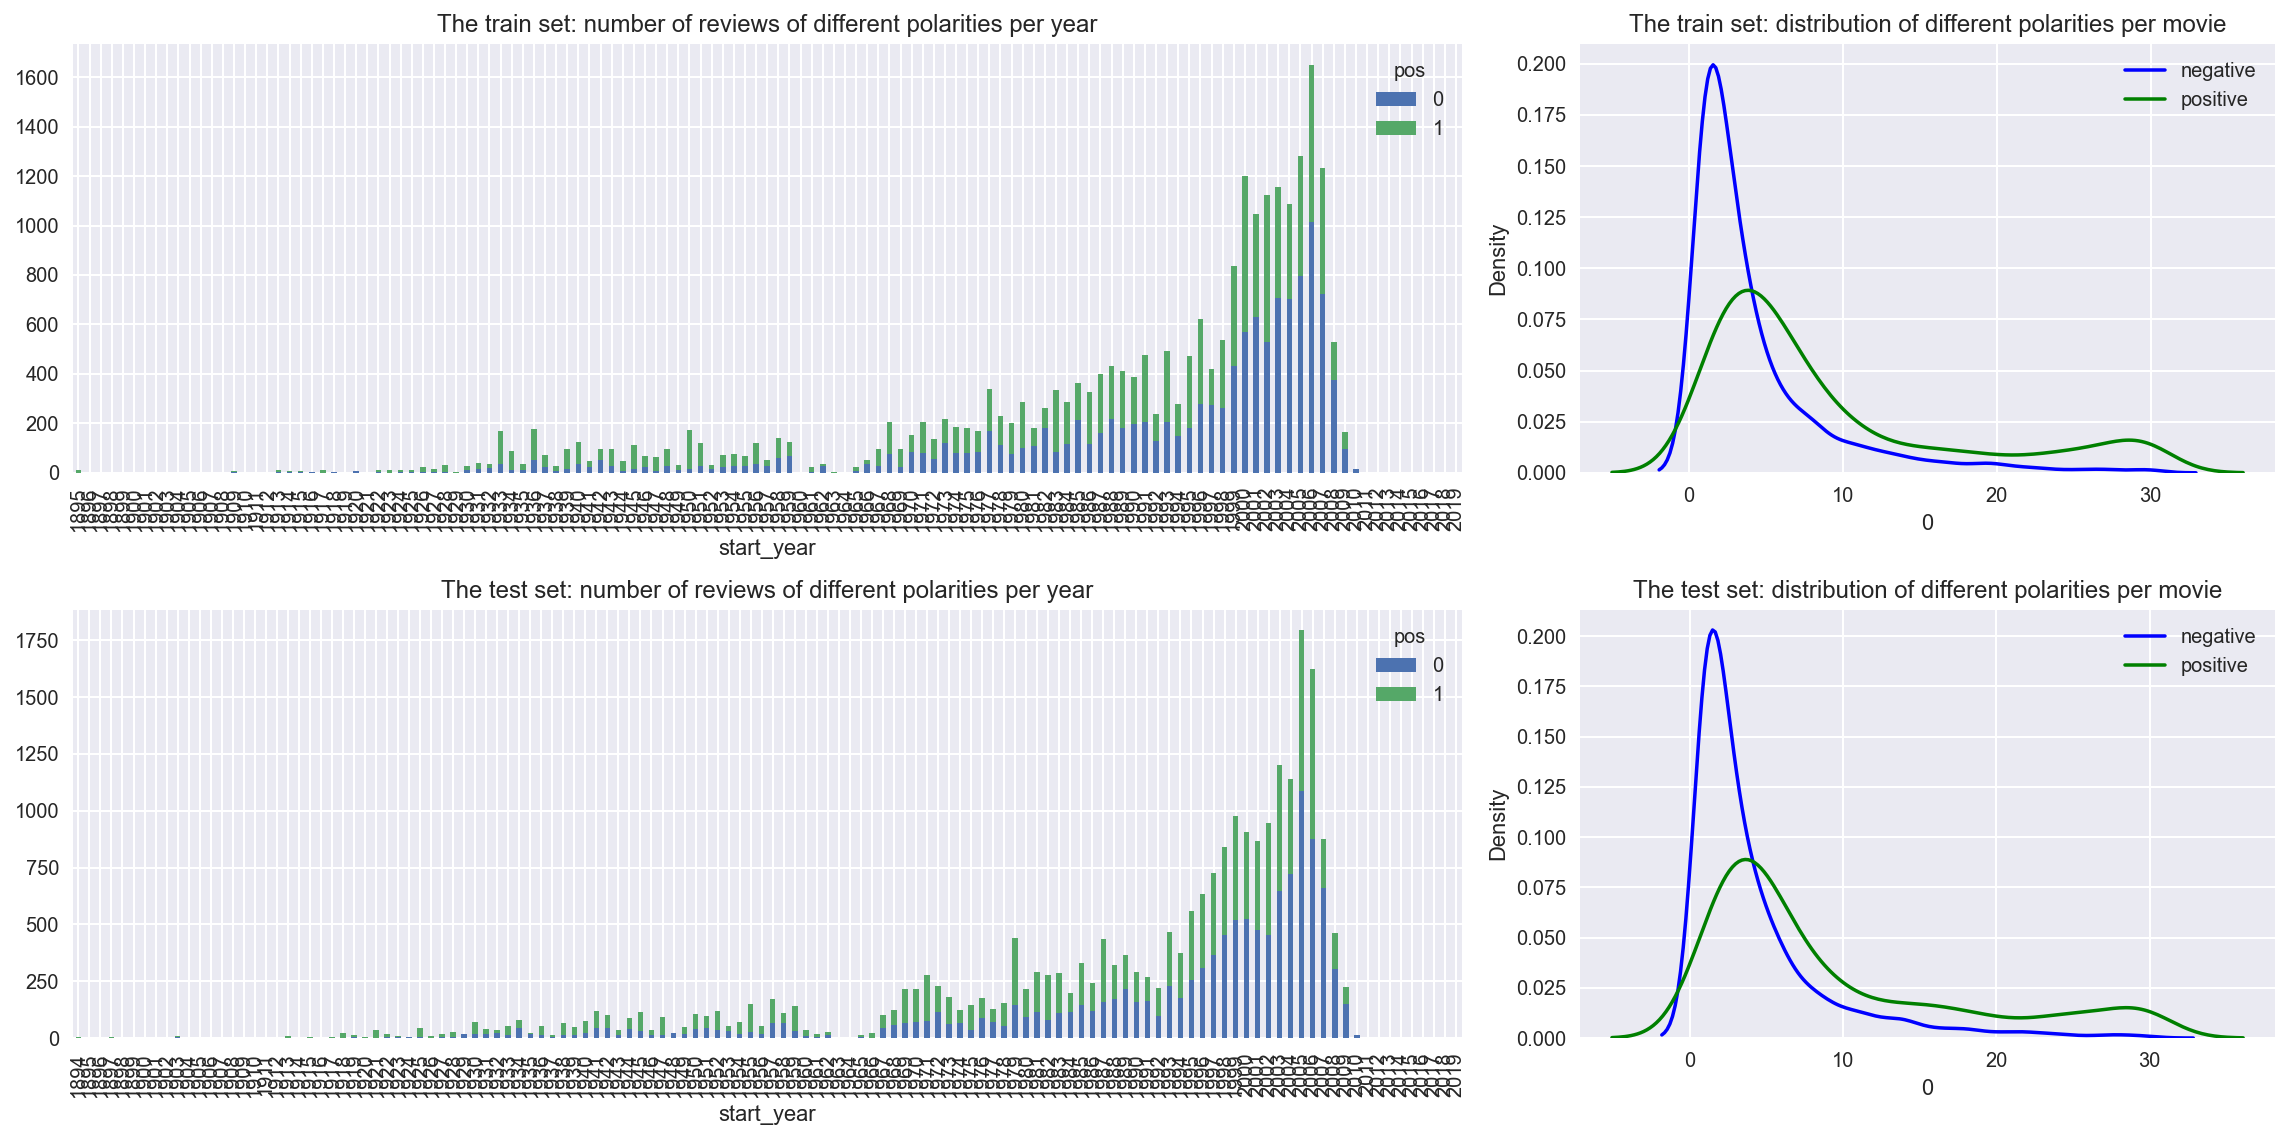

In [368]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Would be nice if you added some comments to these plots. Did you find out anything noteworthy?

</div>

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [369]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = metrics.roc_auc_score

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [370]:
import re

def clear_and_lower_text(row):
    text = row['review']
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    text = " ".join(text)    
    return text

df_reviews['review_norm'] = df_reviews.apply(clear_and_lower_text, axis=1)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Normalization looks good!
    

</div>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [425]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [372]:
from sklearn.metrics import classification_report

def display_classification_report(y_true, y_pred):
    display(pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).T)
    
def plot_roc(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        if not ax: fig, ax = plt.subplots(1, 1)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
        ax.plot([0, 1], [0, 1],'r--')
        ax.plot(fpr, tpr, lw=2, label=label)
        ax.legend(loc='lower right')
        ax.set_title(
             'ROC curve\n'
            f""" AP: {metrics.average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {metrics.auc(fpr, tpr):.2}')
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.annotate(f'AUC: {metrics.auc(fpr, tpr):.2}', xy=(.43, .025))
        ax.legend()
        ax.grid()
        return ax
    

def plot_pr(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        precision, recall, thresholds = metrics.precision_recall_curve(y_test, preds)
        if not ax: fig, ax = plt.subplots()
        ax.plot([0, 1], [1, 0],'r--')    
        ax.plot(recall, precision, lw=2, label=label)
        ax.legend()
        ax.set_title(
            'Precision-recall curve\n'
            f""" AP: {metrics.average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {metrics.auc(recall, precision):.2}'
        )
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.legend()
        ax.grid()
        return ax

## Working with models

### Model 0 - Constant

In [373]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

In [374]:
train_features_0 = df_reviews_train.drop(columns=['pos',], axis=1)
test_features_0 = df_reviews_test.drop(columns=['pos',], axis=1)

In [375]:
model_0 = DummyClassifier()
model_0.fit(train_features_0,train_target)
score = model_0.score(train_features_0, train_target)
print('Train Score ', score)


Train Score  0.5005883341738108


                                                   train  \
Accuracy                                        0.500588   
F1                                                   0.0   
APS                                             0.499412   
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>   

                                                    test  
Accuracy                                        0.501508  
F1                                                   0.0  
APS                                             0.498492  
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>  


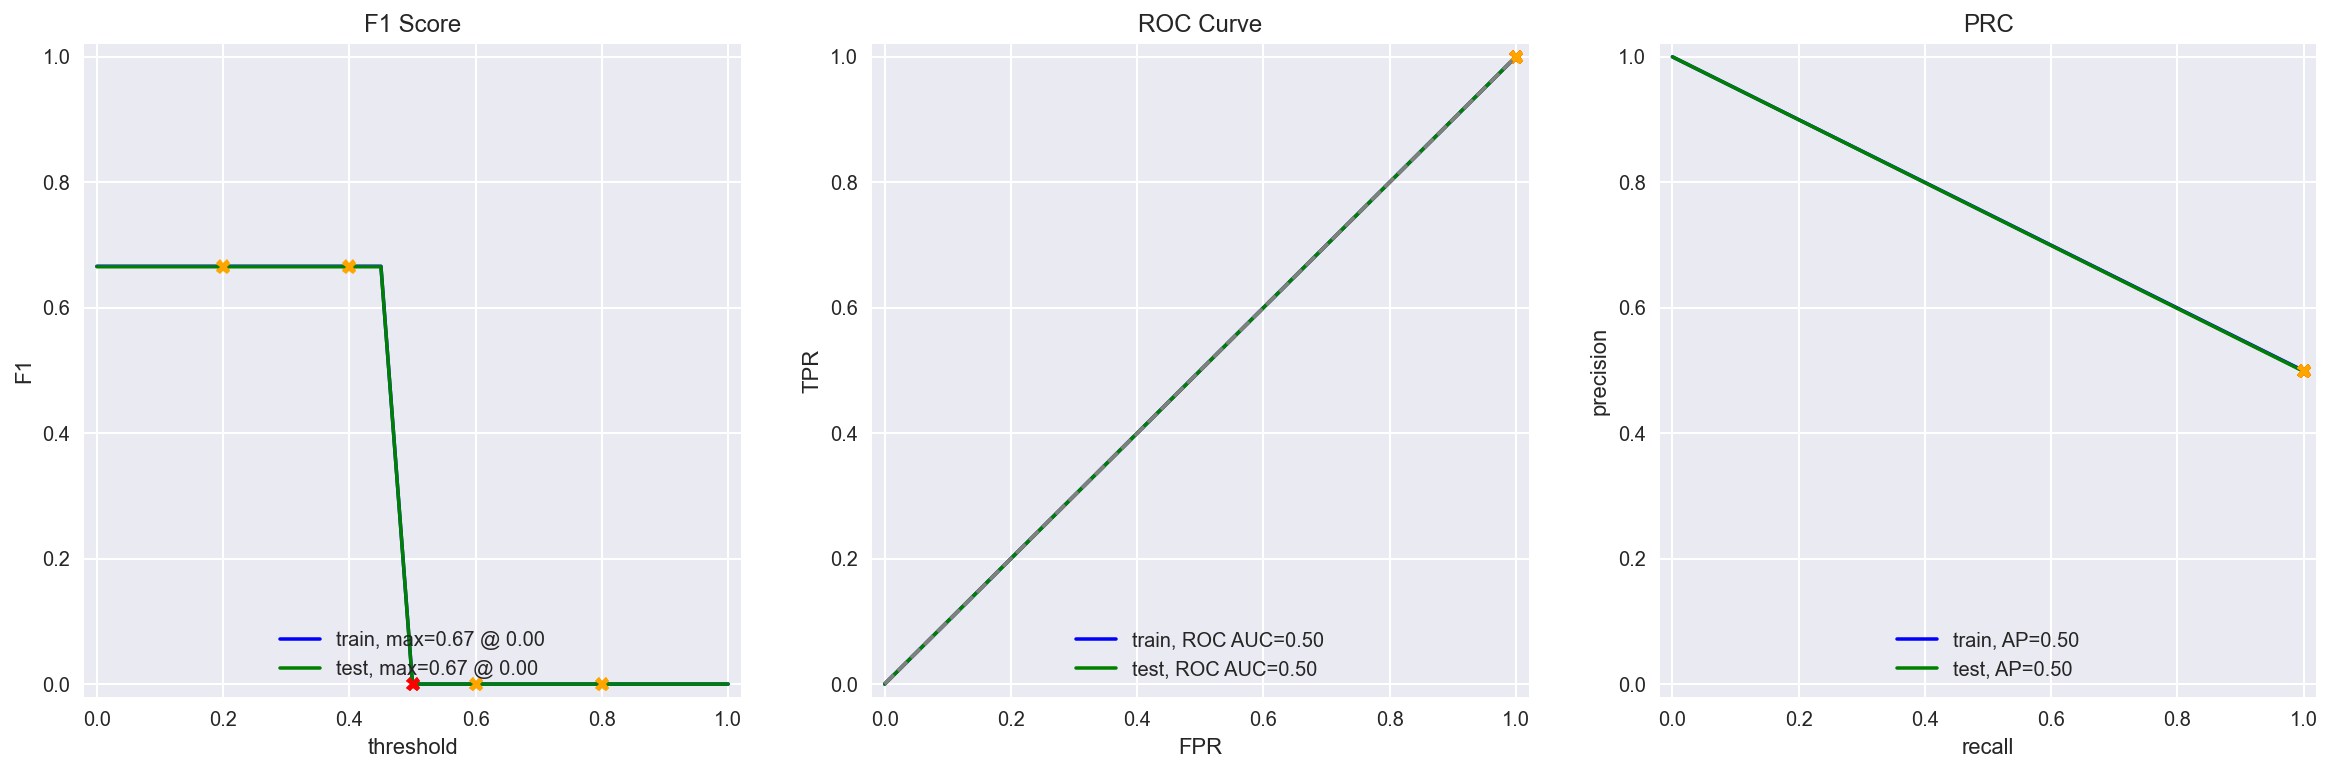

In [378]:
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, there's a simple baseline

</div>

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [379]:
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer()

In [380]:
def text_preprocessing_1(row):
    text = row['review_norm']
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

df_reviews_train['review_lemm_1'] = df_reviews_train.apply(text_preprocessing_1, axis=1)
df_reviews_test['review_lemm_1'] = df_reviews_test.apply(text_preprocessing_1, axis=1)

In [381]:
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
corpus_train = df_reviews_train['review_lemm_1']
corpus_test = df_reviews_test['review_lemm_1']

# creating a TF-IDF matrix without stop words
train_features_1 = count_tf_idf.fit_transform(corpus_train)
test_features_1 = count_tf_idf.transform(corpus_test)

In [382]:
%%time
model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)
score = model_1.score(train_features_1, train_target)
print('Train Score ', score)
test_target = model_1.predict(test_features_1)

Train Score  0.9357455034459573
Wall time: 929 ms


In [489]:
train_tf_idf = count_tf_idf.fit_transform(df_reviews_train["review_norm"])

test_tf_idf = count_tf_idf.transform(df_reviews_test["review_norm"]) 

print('The TF-IDF matrix size:', train_tf_idf.shape)
print('The TF-IDF matrix size:', test_tf_idf.shape)

The TF-IDF matrix size: (23796, 71531)
The TF-IDF matrix size: (23535, 71531)


In [490]:
model_1 = LogisticRegression()
model_1.fit(train_tf_idf,train_target)

LogisticRegression()

                                                   train  \
Accuracy                                        0.937132   
F1                                              0.937589   
APS                                             0.984023   
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>   

                                                    test  
Accuracy                                        0.883025  
F1                                              0.882586  
APS                                             0.949794  
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>  


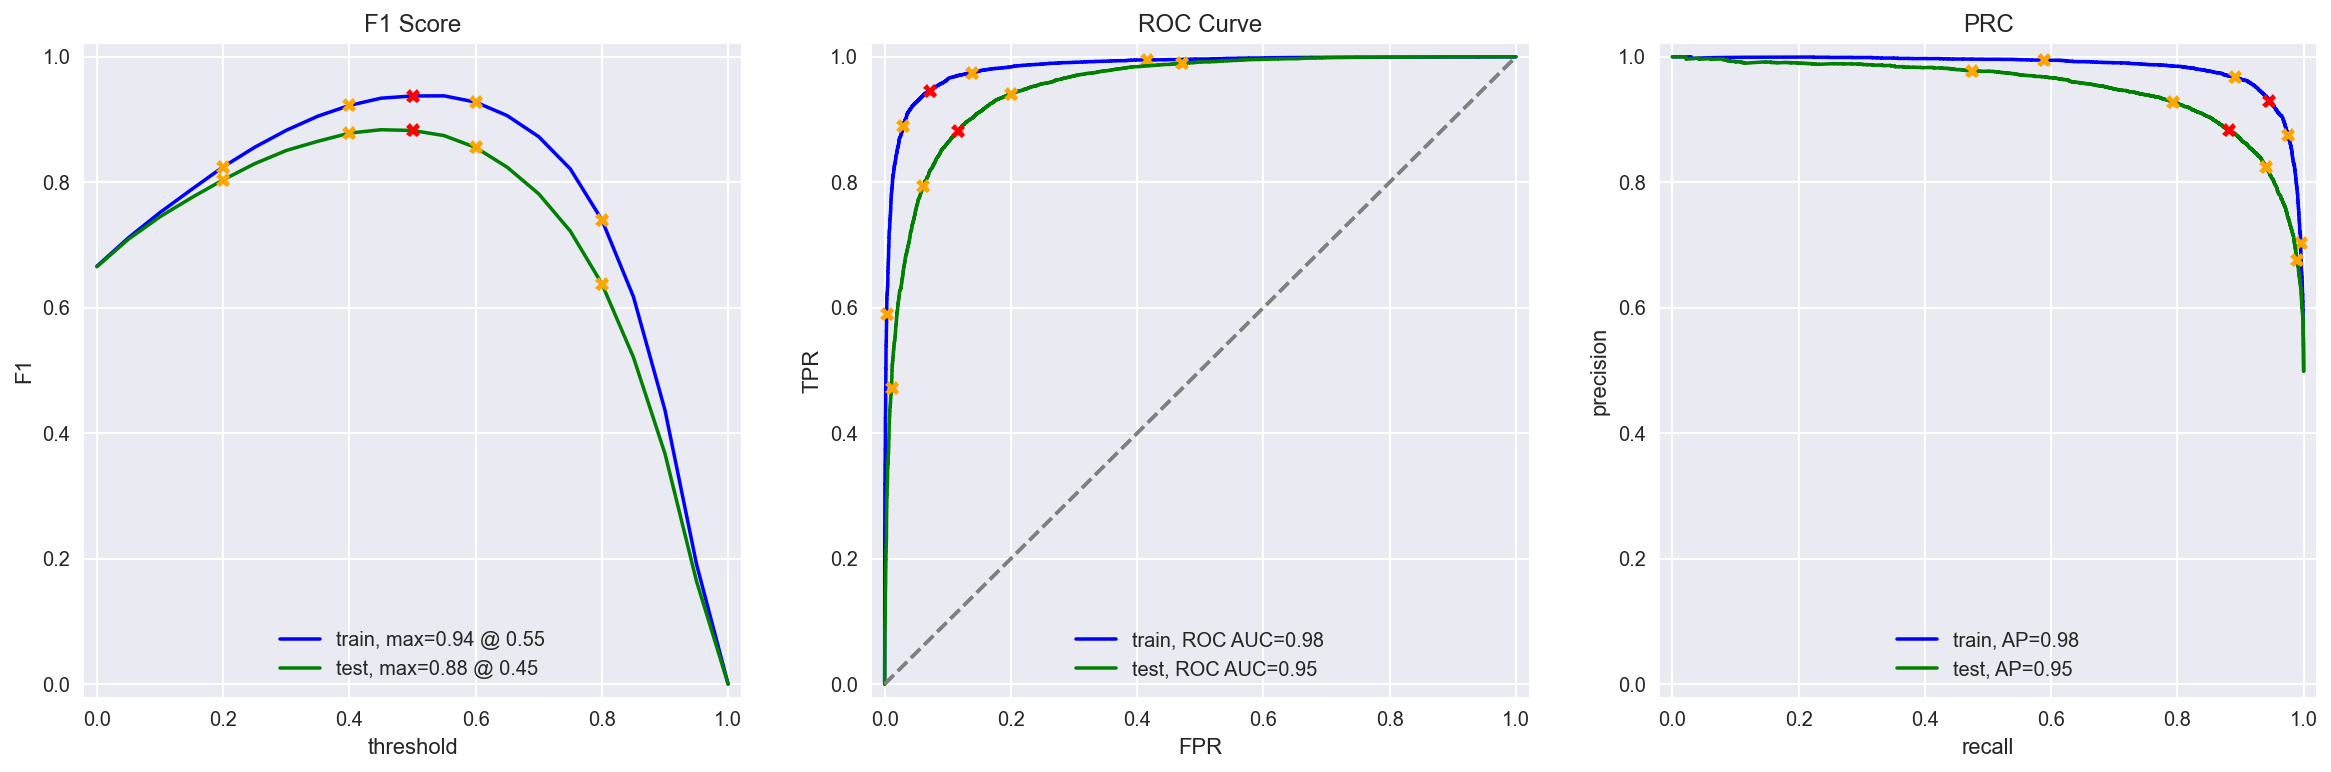

In [493]:
evaluate_model(model_1, train_tf_idf, train_target, test_tf_idf, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [494]:
%%capture
%%bash

pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.4/en_core_web_sm-2.2.4.tar.gz

In [495]:
import spacy
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [496]:
def array_preprocessing_3(X):
  nlp_pipes = nlp.pipe(X, disable=["parser", "ner"],  batch_size=1000)# n_threads=4,
  return np.array([' '.join(token.lemma_ for token in doc) for doc in nlp_pipes])

In [497]:
def text_preprocessing_3(text):
    return ' '.join(token.lemma_ for token in nlp(text))

In [498]:
X_train_tfv = array_preprocessing_3(df_reviews_train["review"].values)
tfv=TfidfVectorizer(min_df=0, max_features=10_000, strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w{3,}', ngram_range=(1,1),
                            use_idf=True,smooth_idf=True, sublinear_tf=True, stop_words = "english")   
X_train_tfv = tfv.fit_transform(X_train_tfv)

In [499]:
X_test_tfv = array_preprocessing_3(df_reviews_test["review"].values)
X_test_tfv = tfv.transform(X_test_tfv)

                                                   train  \
Accuracy                                         0.92318   
F1                                              0.923897   
APS                                             0.976361   
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>   

                                                    test  
Accuracy                                        0.876694  
F1                                              0.876804  
APS                                             0.946134  
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>  


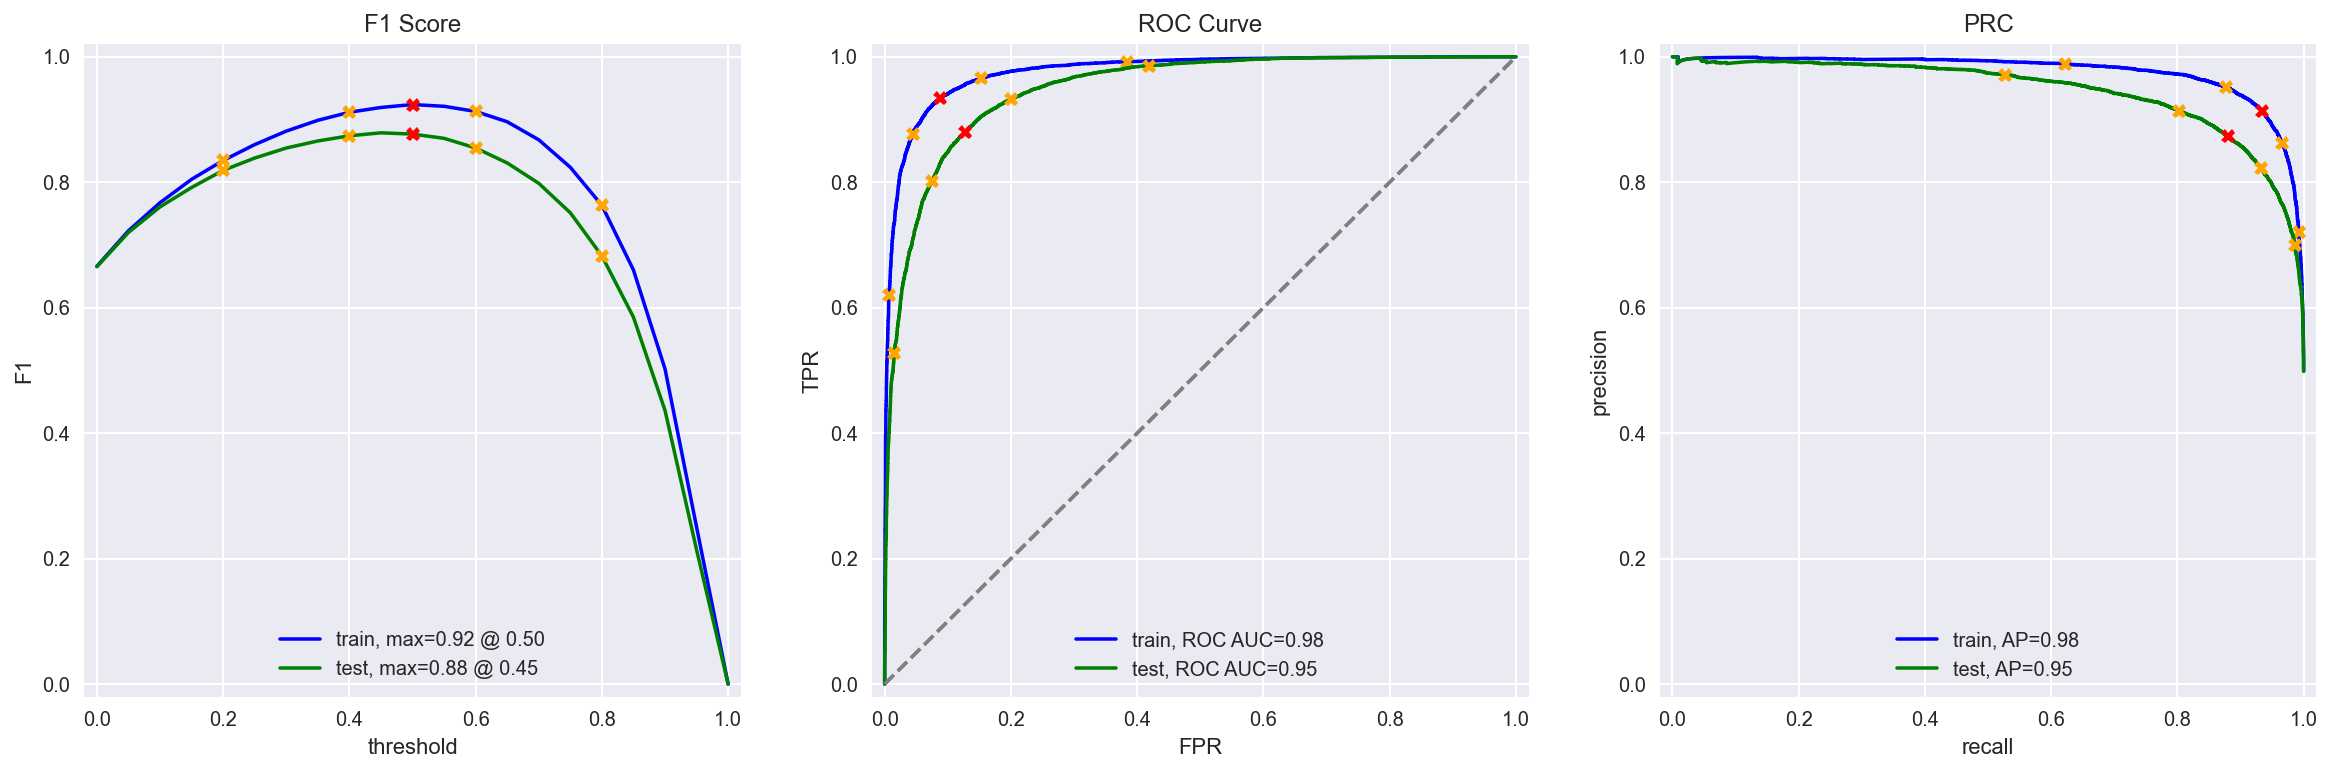

In [500]:
evaluate_model(model_3, X_train_tfv, train_target, X_test_tfv, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [501]:
from lightgbm import LGBMClassifier


                                                   train  \
Accuracy                                        0.907295   
F1                                              0.908305   
APS                                             0.969537   
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>   

                                                    test  
Accuracy                                        0.853665  
F1                                              0.854818  
APS                                              0.92897  
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>  


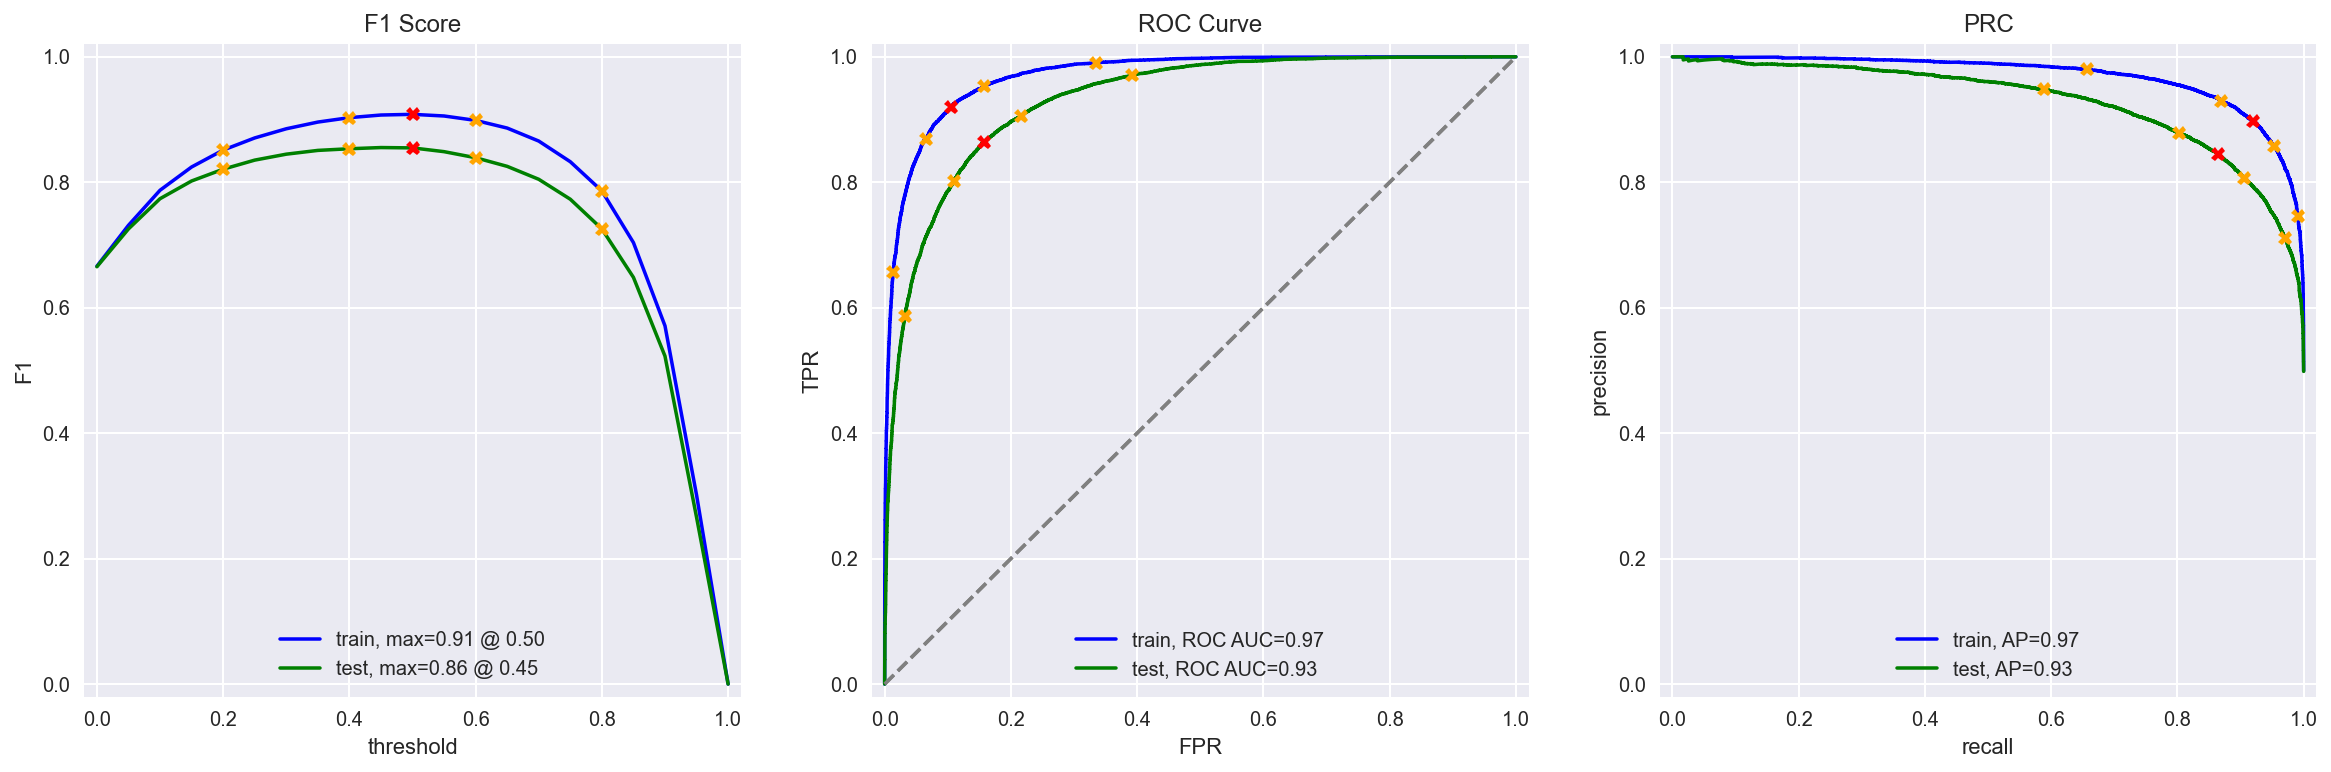

In [502]:
model2 = LGBMClassifier().fit(X_train_tfv, train_target)
y_pred = model2.predict(X_test_tfv)

evaluate_model(model2, X_train_tfv, train_target, X_test_tfv, test_target)


<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you successfully vectorized text data using TF-IDF and trained a couple of different models using the resulting features. It's nice that you tried lemmatization

</div>

###  Model 9 - BERT

In [503]:
import torch
import transformers
from sklearn.model_selection import train_test_split

In [504]:
df_reviews_bert = df_reviews.copy().sample(sample_size).reset_index(drop=True)


In [505]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100):
    
    ids_list = []
    attention_mask_list = []

    max_length = 512

    for input_text in texts.iloc[:sample_size]:
        ids = tokenizer.encode(input_text.lower(), 
                               add_special_tokens=True, 
                               truncation=True, 
                               max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    batch_size = 100

    embeddings = []

    for i in tqdm(range(len(ids_list) // batch_size)):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        
    return np.concatenate(embeddings)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The code for generating BERT embeddings is correct

</div>

In [506]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')
sample_size = 400

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [507]:

features_5 = BERT_text_to_embeddings(df_reviews_bert['review_norm'])
features_5
target_5 = df_reviews.iloc[:sample_size]['pos']
train_features_5,test_features_5,train_target,test_target = train_test_split(features_5,target_5, test_size=0.5, random_state=12345)

  0%|          | 0/4 [00:00<?, ?it/s]

In [511]:
print(df_reviews_train['review_norm'].shape)
print(train_features_5.shape)
print(train_target.shape)


(23796,)
(200, 768)
(200,)


In [514]:
from sklearn.naive_bayes import GaussianNB

model_GNB =  GaussianNB() 
model_GNB.fit(train_features_5,train_target)


GaussianNB()

                                                   train  \
Accuracy                                             0.8   
F1                                              0.805825   
APS                                             0.890845   
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>   

                                                    test  
Accuracy                                            0.48  
F1                                              0.469388  
APS                                             0.417371  
ROC AUC   <function roc_auc_score at 0x0000022BF7CB7DC0>  


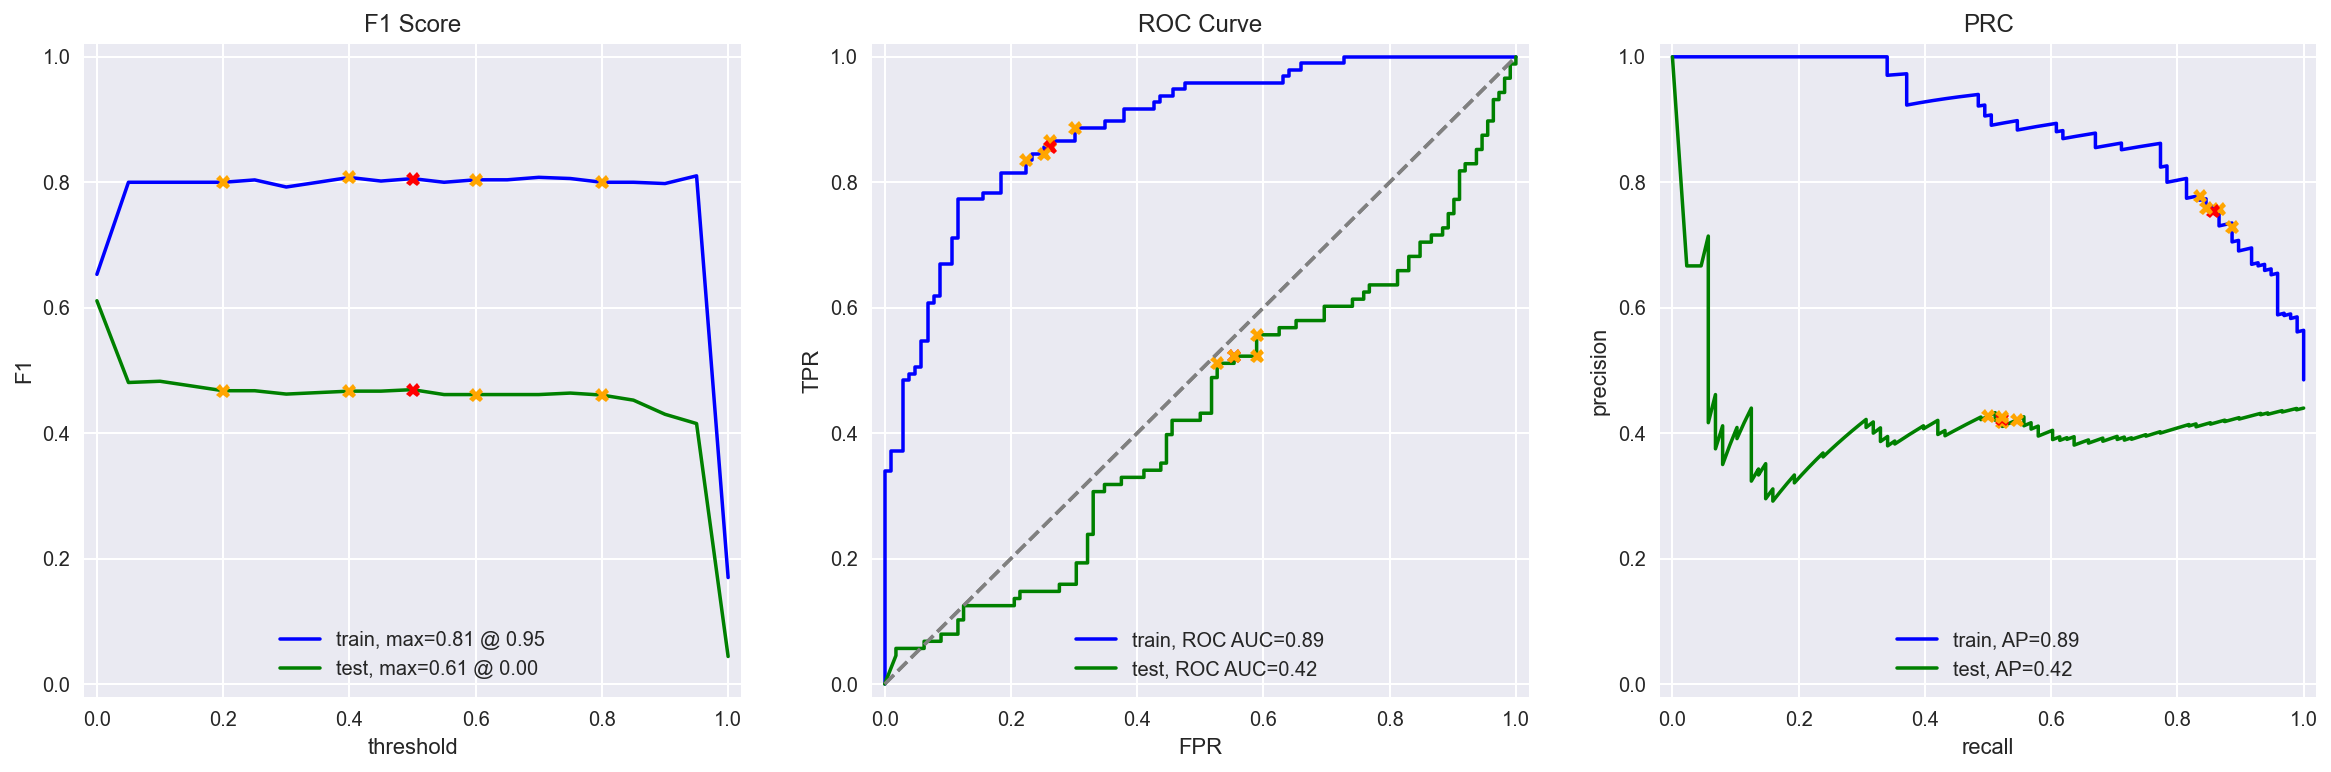

In [515]:
evaluate_model(model_GNB, train_features_5, train_target, test_features_5, test_target)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Ok, keep in mind that the results obtained on such a tiny test set are hardly representative of the model's performance

</div>

In [402]:

score = cross_val_score(model_lr, train_features_5, train_target, cv = None)
print('Train Score ', score)


Train Score  [0.425 0.5   0.425 0.625 0.375]


In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [457]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews.apply(clear_and_lower_text, axis=1)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 3

In [458]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfv.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.18:  i did not simply like it not my kind of movie
0.10:  well i was bored and felt asleep in the middle of the movie
0.49:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.16:  i didn't expect the reboot to be so good writers really cared about the source material
0.49:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.94:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 4

In [461]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfv
my_reviews_pred_prob = model2.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.61:  i did not simply like it not my kind of movie
0.40:  well i was bored and felt asleep in the middle of the movie
0.65:  i was really fascinated with the movie
0.45:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.51:  i didn't expect the reboot to be so good writers really cared about the source material
0.62:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.26:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.81:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Model 9

In order to make the BERT_text_to_embeddings work for s tiny dataset we have to update the batch_size hyperparam. 
We chose batch_size = 2

In [486]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100):
    
    ids_list = []
    attention_mask_list = []

    max_length = 512

    for input_text in texts.iloc[:sample_size]:
        ids = tokenizer.encode(input_text.lower(), 
                               add_special_tokens=True, 
                               truncation=True, 
                               max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    batch_size = 2

    embeddings = []

    for i in tqdm(range(len(ids_list) // batch_size)):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        
    return np.concatenate(embeddings)

In [488]:
texts = my_reviews['review_norm']
my_reviews_features_9 = BERT_text_to_embeddings(texts)

my_reviews_pred_prob = model_lr.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


  0%|          | 0/4 [00:00<?, ?it/s]

1.00:  I did not simply like it, not my kind of movie.
1.00:  Well, I was bored and felt asleep in the middle of the movie.
0.07:  I was really fascinated with the movie
1.00:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.98:  I didn't expect the reboot to be so good! Writers really cared about the source material
1.00:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
1.00:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
1.00:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


<div class="alert alert-success">
<b>Reviewer's comment</b>

The models were applied to custom reviews correctly

</div>

## Conclusions

We started with a labeled dataset of movie reviews. The dataset was cleared of punctuation, lowercased and splitted to train and test sets. 
* Using DummyClassifier as a benchmark we made sure that the data splitting did not change the balance of the labels (the target). The accuracy of the DummyClassifier was only 50%. 
* We then moved to a more advanced method, by tokenizing, lemmatizing and then cleaning the dataset of the stopwords (nltk.corpus library) using TfidfVectorizer. We applied LogisticRegression() classifier and received F1 score of 0.88. and accuracy of 88%.
* Our next method was using the spacy, open source library for NLP. We recleaned the data using spacy library ( spacy.load('en_core_web_sm')), vectorized the dataset again and then run a LogisticRegression() classifier. The results were F1 - 0.87 and accuracy  - 87%
* Moving to our 4th model - we decided to try the already normalized dataset with LGBMClassifier() The result were F1 = 0.85 and accuracy 85%. 
* Our last method was a BERT model ( Bidirectional Encoder Representations from Transformers) that has it’s own unique tokenizer, lemmatizer and text embedder in its’ pre trained NLP transformers. We used the GaussianNB() classifier but received somewhat satisfying results of 48%  accuracy

#### Our best model (88% acc, 0.88 F1), therefore was LogisticRegressor with TfidfVectorizer and nltk library. 


<div class="alert alert-success">
<b>Reviewer's comment</b>

Conclusions make sense

</div>

# Checklist

- [x]  Notebook was opened
- [ ]  The text data is loaded and pre-processed for vectorization
- [ ]  The text data is transformed to vectors
- [ ]  Models are trained and tested
- [ ]  The metric's threshold is reached
- [ ]  All the code cells are arranged in the order of their execution
- [ ]  All the code cells can be executed without errors
- [ ]  There are conclusions